In [39]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, calinski_harabasz_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.cluster import KMeans
# bayestian hyperparameter tunning
import optuna
# models to try
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from xgboost import XGBRegressor

from myvars import input_features
from myfuncs import num_describe
from myclasses import FeatureGenerator, Windsorizer


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Simulate future data

In [2]:
def separate_data():
    data = pd.read_csv('../data/processed/data.csv')
    data = data.dropna(subset=input_features)
    data.query("calendarYear > 2018").to_csv('../data/processed/test.csv', index=False)
    data.query("calendarYear <= 2018").to_csv('../data/processed/train.csv', index=False)
    return None

# Train on different models

In [3]:
data = pd.read_csv('../data/processed/train.csv')
data = data.drop(columns=['symbol', 'calendarYear'])

#### Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='target'),
    np.log(data.target), 
    test_size=0.25, 
    random_state = 46)
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(6023, 112), (2008, 112), (6023,), (2008,)]

#### No model

In [47]:
n = len(y_test)
mean = y_train.mean()
worst_preds = np.tile(mean, n)
mean_squared_error(y_true=np.exp(y_test), y_pred = np.exp(worst_preds))

5421.683404609385

#### Linear Regression

In [7]:
linear_pipe = Pipeline(
    steps = [
        ('feature_generator', FeatureGenerator()),
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('linear_regression', LinearRegression()),
    ]
)
linear_pipe.fit(X_train,y_train)
preds = linear_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse)

(2133.3494299462923, 46.18819578578809)

#### ElasticNet

In [6]:
def custom_score(y, y_pred, **kwargs):
    return mean_squared_error(y_true=np.exp(y), y_pred=np.exp(y_pred))

In [25]:
net = ElasticNet()
mse_scorer = make_scorer(custom_score, greater_is_better=False)
net_params = {
    'alpha' : optuna.distributions.LogUniformDistribution(1e-5, 1e5),
    'l1_ratio' : optuna.distributions.LogUniformDistribution(1e-5, 1),

}
linear_pipe = Pipeline(
    steps = [
        ('feature_generator', FeatureGenerator()),
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('optuna', optuna.integration.OptunaSearchCV(net, param_distributions=net_params, scoring=mse_scorer, n_trials=200, verbose=1)),
    ]
)
linear_pipe.fit(X_train,y_train)
preds = linear_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse)

C:\Users\fpala\AppData\Local\Temp\ipykernel_7264\61277875.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('optuna', optuna.integration.OptunaSearchCV(net, param_distributions=net_params, scoring=mse_scorer, n_trials=200, verbose=1)),
[I 2022-04-16 13:43:47,722] A new study created in memory with name: no-name-dffc7ff5-8cc8-412a-9128-5aec7165ae58
[I 2022-04-16 13:43:47,723] Searching the best hyperparameters using 6023 samples...
[I 2022-04-16 13:43:47,779] Trial 0 finished with value: -6069.918507358072 and parameters: {'alpha': 2.569824266580196, 'l1_ratio': 0.09218709108756037}. Best is trial 0 with value: -6069.918507358072.
[I 2022-04-16 13:43:48,324] Trial 1 finished with value: -2380.101723775858 and parameters: {'alpha': 0.00010080560104405615, 'l1_ratio': 0.0004902120699783965}. Best is trial 1 with value: -2380.101723775858.
[I 2022-04-16 13:43:48,796] Trial 2 finished with value: -2379.90278255360

(2141.9720909251064, 46.28144434787128)

#### Linear SVR

In [45]:
model = LinearSVR(max_iter=2000)
mse_scorer = make_scorer(custom_score, greater_is_better=False)
model_params = {
    'C' : optuna.distributions.LogUniformDistribution(1e-2, 1e2)

}
linear_pipe = Pipeline(
    steps = [
        ('feature_generator', FeatureGenerator()),
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout=300, verbose=1, n_trials=None)),
    ]
)
linear_pipe.fit(X_train,y_train)
preds = linear_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse), linear_pipe['optuna'].best_params_

C:\Users\fpala\AppData\Local\Temp\ipykernel_7264\1446893322.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout=300, verbose=1, n_trials=None)),
[I 2022-04-16 17:41:43,279] A new study created in memory with name: no-name-20650739-f891-4b64-9260-50a3208330cb
[I 2022-04-16 17:41:43,280] Searching the best hyperparameters using 6023 samples...
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-pa

(2094.7676308788236, 45.76863151634341, {'C': 0.9069504986187851})

#### SVM
- Better results. Takes way longer to train: time complexity of at least $O(features * observations^3)$

In [48]:
model = SVR(kernel = 'poly', degree = 2)
mse_scorer = make_scorer(custom_score, greater_is_better=False)
model_params = {
    'C' : optuna.distributions.LogUniformDistribution(1e-4, 1e2),
    'coef0' : optuna.distributions.LogUniformDistribution(1e-4, 1e2),
}
pipe = Pipeline(
    steps = [
        ('feature_generator', FeatureGenerator()),
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout = 5*60, verbose=1, n_trials=None)),
    ]
)
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse), pipe['optuna'].best_params_

C:\Users\fpala\AppData\Local\Temp\ipykernel_7264\414418188.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout = 5*60, verbose=1, n_trials=None)),
[I 2022-04-16 17:48:24,824] A new study created in memory with name: no-name-d3ef95da-a532-439a-b413-a75a5c42db40
[I 2022-04-16 17:48:24,825] Searching the best hyperparameters using 6023 samples...
[I 2022-04-16 17:50:21,130] Trial 0 finished with value: -4268.632979636355 and parameters: {'C': 19.67816809486007, 'coef0': 0.00012123065428636162}. Best is trial 0 with value: -4268.632979636355.
[I 2022-04-16 17:50:39,180] Trial 1 finished with value: -1922.4755296285955 and parameters: {'C': 0.02949793837790296, 'coef0': 83.59202981948808}. Best is trial 1 with value: -1922.4755296285955.
[I 2022-04-16 17:50:53,676] Trial 2 finished with value: -3540.63101

#### KNN
- Best results yet. Very non-lineal, consider KNN, makes sense because its choosing similar results (maybe previous year results, who knows)
- Consider Kmeans or stacking

In [14]:
for a in range(2,15):
    mse_scorer = make_scorer(custom_score, greater_is_better=False)
    model_params = {
        'n_neighbors' : optuna.distributions.IntUniformDistribution(2, 10)
    }
    pipe = Pipeline(
        steps = [
            ('feature_generator', FeatureGenerator()),
            ('feature_clipper', Windsorizer()),
            ('normalizer', PowerTransformer()),
            ('knn', KNeighborsRegressor(n_neighbors=a))
        ]
    )
    pipe.fit(X_train,y_train)
    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
    print(a, mse , np.sqrt(mse))

2 929.5127454524812 30.48791146425877
3 934.5862604067379 30.571003588478053
4 969.385741011709 31.134960109364343
5 1007.523330395855 31.741508004438842
6 1148.4215318932772 33.888368681500104
7 1313.4490336825916 36.24153740782241
8 1440.9727862466764 37.96014734226774
9 1496.3969066791037 38.683289760297065
10 1584.5204588237295 39.80603545724856
11 1690.1729429837494 41.11171296581729
12 1770.5883062398511 42.07835912009701
13 1853.9877385155764 43.05795789996986
14 1913.9012339895103 43.74815692105795


#### KMeans

In [55]:
clusters = []
inertias = []
ch_scores = []
sil_scores = []

pipe = Pipeline(
    steps = [
        ('feature_generator', FeatureGenerator()),
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer())
    ]
)
data = pipe.fit_transform(X_train)
for a in range(2,20):
    print(a)
    kmeans = KMeans(n_clusters=a)
    kmeans.fit(data)
    clusters.append(a)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(data, kmeans.labels_))
    sil_scores.append(silhouette_score(data, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


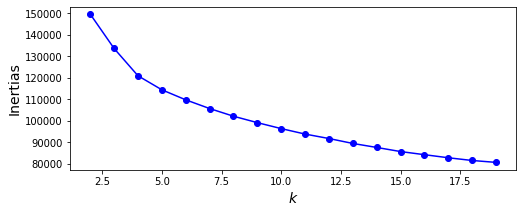

In [56]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertias", fontsize=14)
plt.show()

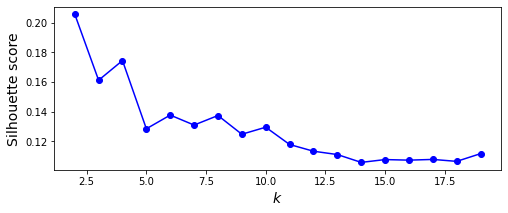

In [57]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

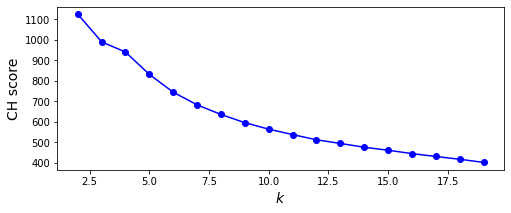

In [58]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, ch_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("CH score", fontsize=14)
plt.show()

In [80]:
for k in range(5,10):
    linear_pipe = Pipeline(
        steps = [
            ('feature_generator', FeatureGenerator()),
            ('feature_clipper', Windsorizer()),
            ('normalizer', PowerTransformer()),
            ('kmeans', KMeans(k)),
            # ('linear_regression', LinearRegression()),
        ]
    )
    linear_pipe.fit(X_train)
    preds = linear_pipe.transform(X_train)
    print(preds.shape)

(6023, 5)
(6023, 6)
(6023, 7)
(6023, 8)
(6023, 9)


This does not do what I want, I want to transform each observation to de distance to its centroid. Building a class for it